In [106]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import math
from textblob import TextBlob
# from better_profanity import profanity

# Nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [107]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

In [108]:
# borrowed from stackoverflow https://stackoverflow.com/a/49146722
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def remove_unwanted(document):

    # remove URLS 
    document = re.sub(r'http\S+', ' ', document)
    # remove emoji's
    document = remove_emoji(document)
    # remove punctuation
    document = re.sub("[^0-9A-Za-z ]", "" , document)
    # remove double spaces
    document = document.replace('  ',"")
    
    return document.strip()

In [109]:
def lemmatize_text(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    words_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]   
    lemma_list = [wd.lemmatize(tag) for wd, tag in words_tags]
    
    lemmatized_sentence = " ".join(lemma_list)
    return lemmatized_sentence

In [110]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [111]:
data = pd.read_csv("Harvey_stressor.csv")

exclusive_emotion = ["approval","desire","admiration","love","gratitude","excitement","optimism","joy","amusement","neutral"]
extracted_data = data.loc[~data["Emotion"].isin(exclusive_emotion)].reset_index()

extracted_data['Tweet']=extracted_data['Tweet'].astype(str)

text_corpus = extracted_data["Tweet"].astype(str)
len(text_corpus)

98229

In [112]:
text_corpus

0        As Hurricane Harvey is fast approaching now is...
1        If youre able give blood at RedCrossDonate blo...
2        Lifethreatening Hurricane Harvey head toward T...
3        Daddy please get out of the way of HurricaneHa...
4        Everyone please pray for Texas Hurricane Harve...
                               ...                        
98224     How You Can Help the Victims of Hurricane Harvey
98225         Hurricane Harvey How to help in time of need
98226    To everyone affected by Hurricane Harvey send ...
98227    Our thought are with our neighbor in the South...
98228    Marylanders head to Texas to assist with Hurri...
Name: Tweet, Length: 98229, dtype: object

### This section is for expansion purpose

In [113]:
# climate_data = []
# vocab = ["climate","warming","global","change","carbon","pollution","greenhouse","energy","fossil","fuel","hoax"]
# words_re = re.compile("|".join(vocab))

# for tweet in text_corpus:
#     if words_re.search(tweet):
#         climate_data.append(tweet)

# len(climate_data)

In [114]:
new_corpus = []

for text in text_corpus:

    clean_text = remove_unwanted(str(text))
    clean_text = ' '.join([w for w in clean_text.split() if len(w)>1])
    clean_text = lemmatize_text(clean_text)
    new_corpus.append(clean_text)

# new_corpus = np.array(new_corpus)

In [115]:
new_corpus

['As Hurricane Harvey be fast approach now be the time to do what you can to prepare your property to minimize',
 'If youre able give blood at RedCrossDonate blood time money skillsHurricane Harvey be bad oneunite help serve',
 'Lifethreatening Hurricane Harvey head toward Texas coastx000D pictwittercom8R18AJKuYf',
 'Daddy please get out of the way of HurricaneHarvey need you safe',
 'Everyone please pray for Texas Hurricane Harvey be nearly category storm and it go to hover there for at least three day',
 'Hi Maria Will Bush AirportHobby Expect SuperStorm Sandys Storm Surge with Hurricane Harveypictwittercomt8oVNqDxkp',
 'Praying for Corpus ChristiHoustonHurricaneHarvey',
 'For all of you in HurricaneHarvey territory hope you find way to stay safe Ill keep you all in my thought',
 'To everyone in TexasPlease get to safety and if your stay put get to safetyHurricaneHarvey',
 'Texans Told to Evacuate Ahead of Hurricane Harvey Massive Storm Approaches Dont Take Any Chances',
 'Going to M

In [116]:
# clean_tweet_data = np.array(new_corpus)
# extracted_data["Tweet"] = clean_tweet_data
# extracted_data.to_csv('Harvey_stressor.csv',index=False)

In [117]:
stop_words = stopwords.words('english')
extended_words = ["hurricaneharvey","hurricane","harvey","texas","austin","galveston","storm","winds","houston","david","usa","twitter","donald",
                  "trump","trumps","san","hey","houstons","southeast","tomorrow","else","potus"," harveys","texans","via","wind","tx","harvey2017",
                  "corpus","christi","harveys","mph","category","cat","gulf","coast","hurricanharvey","category4","x000dhurricaneharvey","x000dhurricanharvey",
                  "ha","wa","130","harveyx000d","hurricaineharvey","x000d","atonio","harveystay","mexico","2017","louisiana","corpuschristi"]
stop_words.extend(extended_words)

In [118]:
tokenizer = RegexpTokenizer(r'\w+')

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize,
                        max_features=500,
                        encoding='utf-8')

train_data = tfidf.fit_transform(new_corpus)


In [119]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names_out()
top_n = 50
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

['word', 'snapchat', 'havent', 'texashurricaneharvey', 'ur', 'service', 'sustained', 'include', 'scared', 'administration', 'food', 'strength', 'horrible', 'literally', 'alligator', 'ban', 'drown', 'government', 'inch', 'pls', 'barrel', 'sustain', 'prayersfortexas', 'potential', 'nature', 'absolutely', 'ago', 'probably', 'important', 'seem', 'able', 'play', 'assist', 'fly', 'problem', 'build', '130mph', 'saturday', 'others', 'heed', 'smart', 'neighbor', 'rn', 'southern', 'terrible', 'surround', 'station', 'world', 'massive', 'staysafe']


In [120]:
# Materialize the sparse data
data_dense = train_data.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.7769334921459039 %


## SAMPLE LDA

In [121]:
warnings.filterwarnings('ignore')
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations  
                                      random_state=100,          # Random state
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(train_data)

pprint(lda_model)  # Model attributes

LatentDirichletAllocation(n_components=20, n_jobs=-1, random_state=100)


In [122]:
avg_coherence = get_average_topic_coherence(train_data, lda_model.components_, 10)
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(train_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(train_data))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1230441.1912111493
Perplexity:  936.3674935286787
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## GridSearch LDA

In [123]:
# Define Search Param
topic_number = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125]
# decay_rate = [0.5, 0.7, 0.9]
coherence_score = []
for i in topic_number:
    lda_model = LatentDirichletAllocation(n_components=i,            # Number of topics
                                        learning_decay= 0.7,
                                        max_iter=10,               # Max learning iterations  
                                        random_state=100,          # Random state
                                        evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                        n_jobs = -1,               # Use all available CPUs
                                        )
    lda_output = lda_model.fit_transform(train_data)
    coherence_score.append(get_average_topic_coherence(train_data, lda_model.components_, 25))
    print("LDA model with "+str(i)+" topics is done!")
        
coherence_score = np.array(coherence_score)

LDA model with 20 topics is done!
LDA model with 25 topics is done!
LDA model with 30 topics is done!
LDA model with 35 topics is done!
LDA model with 40 topics is done!
LDA model with 45 topics is done!
LDA model with 50 topics is done!
LDA model with 55 topics is done!
LDA model with 60 topics is done!
LDA model with 65 topics is done!
LDA model with 70 topics is done!
LDA model with 75 topics is done!
LDA model with 80 topics is done!
LDA model with 85 topics is done!
LDA model with 90 topics is done!
LDA model with 95 topics is done!
LDA model with 100 topics is done!
LDA model with 105 topics is done!
LDA model with 110 topics is done!
LDA model with 115 topics is done!
LDA model with 120 topics is done!
LDA model with 125 topics is done!


In [124]:
# plotting_coherence = np.delete(coherence_score,0)
np.savetxt('coherence_score_with_lemma.out', coherence_score, delimiter=',')

In [125]:
plotting_coherence = np.loadtxt("coherence_score_with_lemma.out", dtype=float)

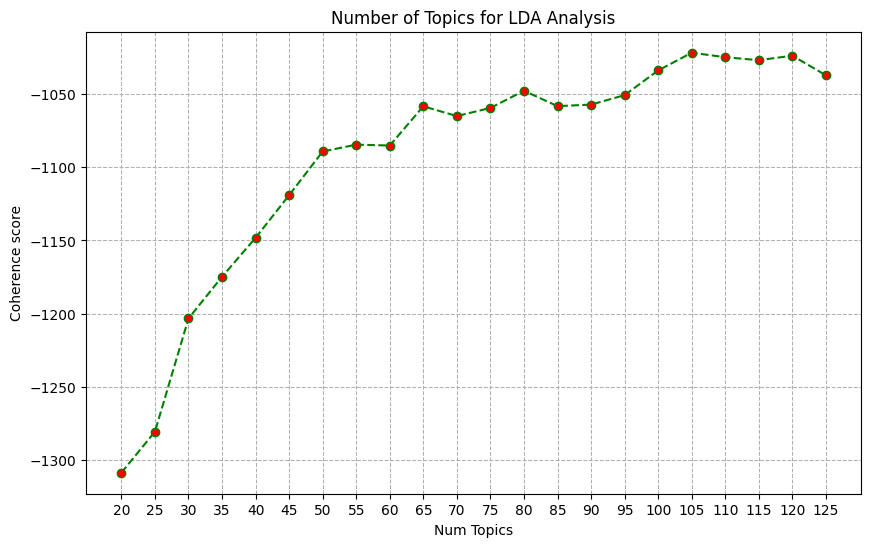

In [138]:
topics_no = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125]
plt.figure(figsize=(10,6))

plt.plot(topics_no,plotting_coherence, linestyle='--', marker='o', c='green', mfc='red')
plt.title("Number of Topics for LDA Analysis")
plt.xlabel("Num Topics")
plt.xticks([20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125])

plt.ylabel("Coherence score")
plt.grid(which ='major',linestyle='--', linewidth=0.75)
plt.show()

In [127]:
plotting_coherence

array([-1308.62682616, -1280.59523825, -1203.29264445, -1174.81612638,
       -1148.17610368, -1119.12042048, -1089.2341256 , -1084.5896661 ,
       -1085.18262655, -1058.41079483, -1065.06536839, -1059.50799838,
       -1047.8018781 , -1058.29382687, -1057.23522168, -1050.77942726,
       -1033.89837895, -1021.80743333, -1024.86436606, -1026.90979794,
       -1023.84737526, -1037.23494139])

In [139]:
topic_no = 105
lda_model = LatentDirichletAllocation(n_components=topic_no,            # Number of topics
                                    learning_decay= 0.7,
                                    max_iter=10,               # Max learning iterations  
                                    random_state=100,          # Random state
                                    evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                    n_jobs = -1,               # Use all available CPUs
                                    )
lda_output = lda_model.fit_transform(train_data)
pprint(lda_model.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 100,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [140]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(train_data)

# column names
topicnames = ["Topic" + str(i) for i in range(topic_no)]

# index names
docnames = ["Doc" + str(i) for i in range(len(new_corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'white'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(30).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39,Topic40,Topic41,Topic42,Topic43,Topic44,Topic45,Topic46,Topic47,Topic48,Topic49,Topic50,Topic51,Topic52,Topic53,Topic54,Topic55,Topic56,Topic57,Topic58,Topic59,Topic60,Topic61,Topic62,Topic63,Topic64,Topic65,Topic66,Topic67,Topic68,Topic69,Topic70,Topic71,Topic72,Topic73,Topic74,Topic75,Topic76,Topic77,Topic78,Topic79,Topic80,Topic81,Topic82,Topic83,Topic84,Topic85,Topic86,Topic87,Topic88,Topic89,Topic90,Topic91,Topic92,Topic93,Topic94,Topic95,Topic96,Topic97,Topic98,Topic99,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,83
Doc1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000,0.000000,0.000000,0.190000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52
Doc2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82
Doc3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [151]:
extracted_data["Topic_number"] = np.array(dominant_topic)
extracted_data.to_csv('Harvey_stressor_with_topics.csv',index=False)


In [141]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,4806
1,28,3277
2,67,2815
3,50,2773
4,33,2408
...,...,...
95,45,373
96,93,349
97,1,332
98,66,303


In [156]:
# Print the topics with their terms
terms = tfidf.get_feature_names_out()
lda_components = lda_model.components_
with open("Topic_term.txt", 'w') as f:
    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
        top_terms_list=list(dict(top_terms_key).keys())
        line = "Topic "+str(index)+": "+str([w for w in top_terms_list])
        # print(line)
        f.write(line)
        f.write('\n')

In [143]:
cluster_no = lda_model.n_components

# Construct the k-means clusters
clusters = KMeans(n_clusters=cluster_no, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.05  0.04  0.06  0.08  0.09  0.08  0.08  0.09  0.08  0.06  0.05  0.08
   0.08  0.05  0.06  0.09  0.11  0.08  0.12  0.08  0.12  0.07  0.07  0.08
   0.13  0.07  0.07  0.07  0.47  0.07  0.06  0.06  0.08  0.2   0.06  0.05
   0.07  0.07  0.08  0.09  0.08  0.06  0.07  0.06  0.05  0.04  0.13  0.07
   0.07  0.05  0.34  0.06  0.06  0.08  0.06  0.08  0.15  0.08  0.07  0.06
   0.07  0.06  0.08  0.07  0.09  0.07  0.05  0.27  0.07  0.08  0.07  0.07
   0.05  0.06  0.07  0.08  0.06  0.08  0.1   0.05  0.06  0.07  0.07  0.08
   0.06  0.08  0.05  0.08  0.08  0.1   0.06  0.06  0.06  0.05  0.06  0.08
   0.09  0.06  0.04  0.07]
 [ 0.01  0.    0.01  0.    0.01  0.01  0.    0.01  0.01  0.    0.01  0.01
   0.01  0.    0.    0.    0.    0.01  0.01  0.01  0.01  0.01  0.    0.
   0.    0.01  0.01  0.01 -0.64  0.    0.    0.    0.    0.    0.    0.
   0.    0.01  0.    0.    0.01  0.    0.    0.    0.    0.   -0.01  0.01
   0.01  0.01  0.77  0.    0.    0.01  0.01  0.   -0.   -0.    0.0

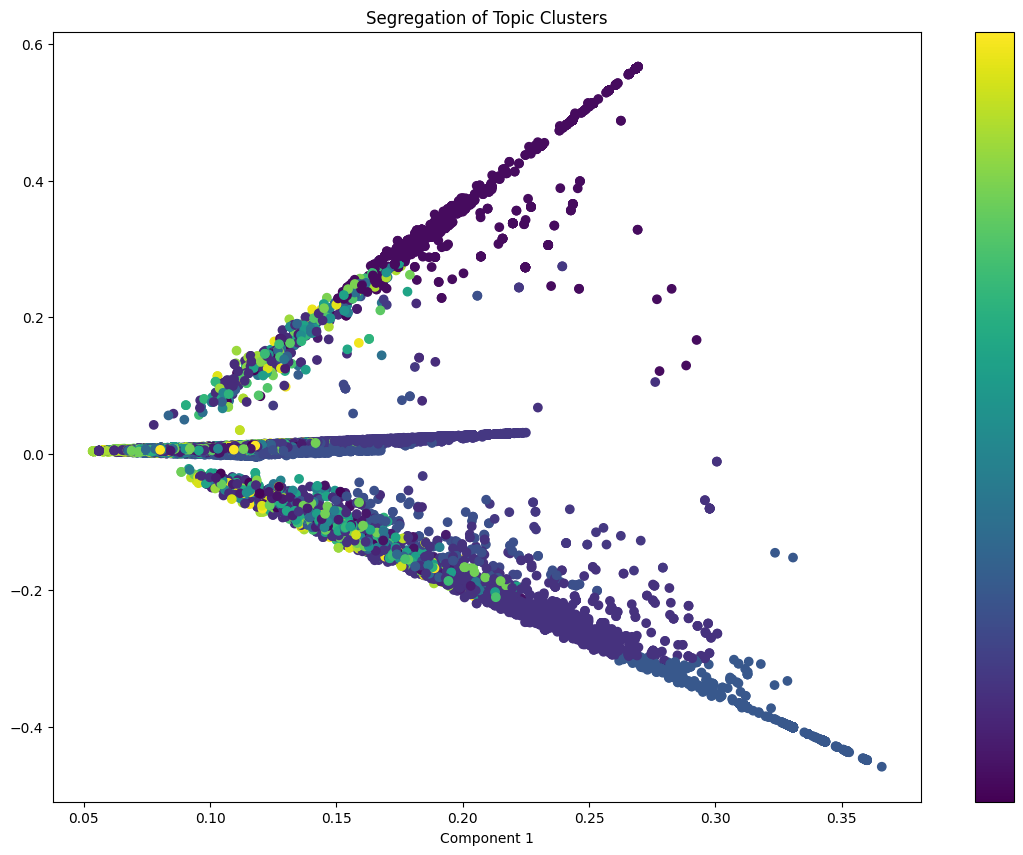

In [144]:
# Plot
plt.figure(figsize=(14, 10))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.colorbar(ticks=[])

In [145]:
import pyLDAvis.lda_model

In [146]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model,train_data,tfidf)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
28    -0.292326 -0.083294       1        1  2.376728
67    -0.282512 -0.062000       2        1  2.224053
33    -0.212101 -0.021503       3        1  1.875203
50    -0.260306 -0.108675       4        1  1.818257
24     0.085698 -0.068076       5        1  1.588336
...         ...       ...     ...      ...       ...
49     0.031529 -0.122308      96        1  0.664015
66     0.003761 -0.059362      97        1  0.614981
45     0.088639 -0.119866      98        1  0.567926
1     -0.129602 -0.049777      99        1  0.540802
98    -0.095524 -0.078820     100        1  0.517297

[100 rows x 5 columns], topic_info=          Term        Freq        Total  Category  logprob  loglift
314    prayers  1461.00000  1461.000000   Default  30.0000  30.0000
312       pray  1782.00000  1782.000000   Default  29.0000  29.0000
317    praying  1383.00000  1383.000000   Default  28.0000  28.0000
81        come   992.00000   992.000000   Default  27.0000  27.0000
187       help  2094.00000  2094.000000   Default  26.0000  26.0000
..         ...         ...          ...       ...      ...      ...
7     affected     0.01987   183.203257  Topic100 -10.7541  -3.8648
8    aftermath     0.01987   164.551150  Topic100 -10.7541  -3.7575
10       ahead     0.01987   170.203064  Topic100 -10.7541  -3.7912
11         aid     0.01987   138.371580  Topic100 -10.7541  -3.5842
12        aint     0.01987   271.481249  Topic100 -10.7541  -4.2581

[3338 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        41  0.997407          12
1        98  0.995978      130mph
2        69  0.990310        able
3        71  0.992388  absolutely
4        43  0.992068    actually
...     ...       ...         ...
498      77  0.013559       youre
498      79  0.023243       youre
498      92  0.011622       youre
499      16  0.730174     youtube
499      72  0.267296     youtube

[3411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[29, 68, 34, 51, 25, 47, 57, 21, 19, 17, 90, 79, 8, 13, 9, 65, 7, 96, 41, 86, 40, 54, 24, 6, 84, 89, 5, 39, 12, 70, 58, 97, 88, 78, 20, 33, 16, 43, 63, 56, 22, 100, 71, 69, 26, 4, 30, 61, 75, 48, 66, 38, 18, 64, 76, 28, 31, 27, 83, 72, 37, 35, 82, 85, 59, 98, 77, 23, 53, 92, 49, 55, 32, 42, 93, 15, 95, 91, 74, 62, 36, 44, 81, 3, 52, 60, 10, 87, 80, 94, 14, 45, 11, 73, 1, 50, 67, 46, 2, 99])

## Auxiliary Testing

In [147]:
# # Define the number of topics or components
# num_components=10

# # Create LDA object
# model=LatentDirichletAllocation(n_components=num_components)

# # Fit and Transform SVD model on data
# lda_matrix = model.fit_transform(train_data)

# # Get Components 
# lda_components=model.components_

In [148]:
# Print the topics with their terms
# terms = tfidf.get_feature_names_out()

# for index, component in enumerate(lda_components):
#     zipped = zip(terms, component)
#     top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
#     top_terms_list=list(dict(top_terms_key).keys())
#     print("Topic "+str(index)+": ",top_terms_list)